# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 23

**Author 1 (sciper):** Jérémy Baffou (301972)  
**Author 2 (sciper):** Léon Delachaux (296093)   
**Author 3 (sciper):** Martin Dahl (344218)  

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

# Imports

In [27]:
import numpy as np
import cv2 as cv
import skimage.io
import scipy.signal as signal
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
%matplotlib inline


---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

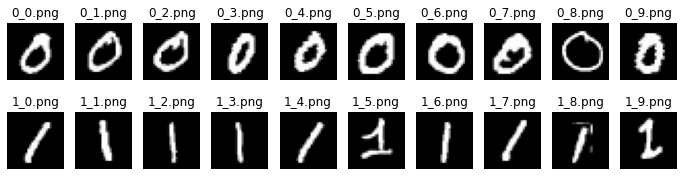

In [95]:
def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

In [4]:
# Add your implementation and discussion

# Step 1: thresholding
# Step 2: open
# Step 3: follow contour
# Step 4: Fourier descriptors of contour

**0. Consider histogram for thresholding**

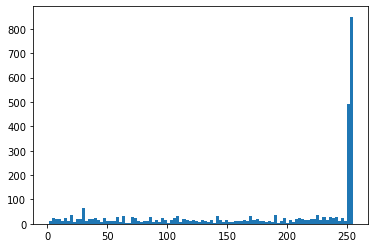

In [5]:
# All images flattened into one row vector
all_images = np.concatenate((ones_im, zeros_im))
all_images_flattened = np.reshape(all_images, (20*28*28))

# Removing zeros since these are obviously not our digits and scew the histogram below
all_images_flattened_no_zeros = np.delete(all_images_flattened, np.where(all_images_flattened == 0)) 

# Histogram
plot = plt.hist(all_images_flattened_no_zeros, bins=100)

Looking at/using the histogram does not give us a good indication of where to set threshold, thus this is found by trial. 

**1. Thresholding, setting T by trial**

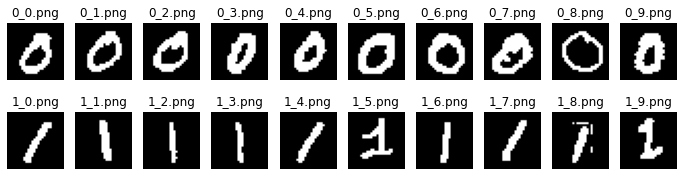

In [6]:
# Thresholding
T = 50

ones_thresholded = ones_im.copy()
zeros_thresholded = zeros_im.copy()
ones_thresholded[ones_thresholded < T] = 0 
ones_thresholded[ones_thresholded != 0] = 1 
zeros_thresholded[zeros_thresholded < T] = 0 
zeros_thresholded[zeros_thresholded != 0] = 1 

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_thresholded, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_thresholded, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

**2. Morphological open to remove noise**

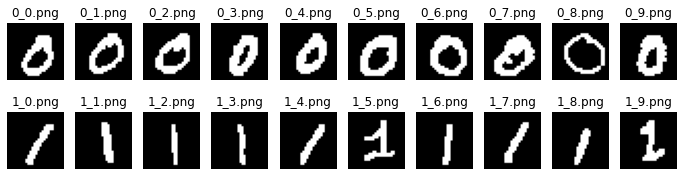

In [7]:
# https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

kernel = np.ones((2,2),np.uint8)

for i in range(10):
    ones_thresholded[i,:] = cv.morphologyEx(ones_thresholded[i,:], cv.MORPH_OPEN, kernel)
    zeros_thresholded[i,:] = cv.morphologyEx(zeros_thresholded[i,:], cv.MORPH_OPEN, kernel)
    
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_thresholded, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_thresholded, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

Some digits end up too thin, this will cause problem with boundary tracking algorithm below. Thats why we dilate it again with a 2x2 kernel:

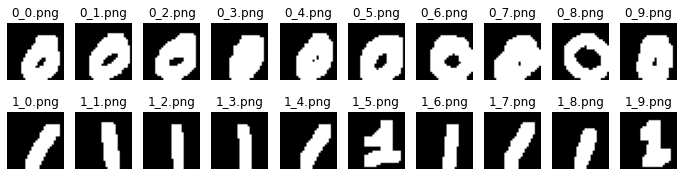

In [87]:
kernel = np.ones((2,2),np.uint8)
for i in range(10):
    ones_thresholded[i,:] = cv.dilate(ones_thresholded[i,:],kernel,iterations = 1)
    zeros_thresholded[i,:] = cv.dilate(zeros_thresholded[i,:],kernel,iterations = 1)
                                       
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_thresholded, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_thresholded, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#### Digit processing pipeline

In [98]:
def process_digit(im_set):
    # Threshold for binary image
    T = 50
    im_set_thresholded = im_set.copy()
    im_set_thresholded[im_set_thresholded < T] = 0 
    im_set_thresholded[im_set_thresholded != 0] = 1
    # Open to remove noise
    kernel = np.ones((2,2),np.uint8)
    for i in range(im_set.shape[0]):
        im_set_thresholded[i,:] = cv.morphologyEx(im_set_thresholded[i,:], cv.MORPH_OPEN, kernel)
    # Dilate once to have thicker digits
    kernel = np.ones((2,2),np.uint8)
    for i in range(im_set.shape[0]):
        im_set_thresholded[i,:] = cv.dilate(im_set_thresholded[i,:],kernel,iterations = 1)
    return im_set_thresholded

ones_thresholded = process_digit(ones_im)
zeros_thresholded = process_digit(zeros_im)

**3. Tracking contours to create sequence u**

We will not consider the inner contour of 0, 4, 6, 8, 9, only the outer for a start

[-5.59671415e+02-93.94294607j  2.56156571e+00 +7.09378579j
 -4.94666802e+00-15.63843902j -2.24116237e-01 -4.85427644j
  1.01351643e+01 +8.40144545j  1.20628814e+00 -0.38913582j
 -6.32146466e+00 +4.97292702j  1.34628711e-02 +0.65261966j
 -4.40643479e+00 -3.78175752j  1.59259226e-01 -0.51235591j]


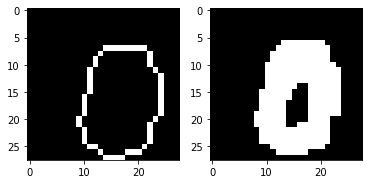

In [99]:
directions = np.asarray([[1,-1],[1,1],[-1,1],[-1,-1],[0,-1],[1,0],[0,1],[-1,0]]) # Trigonometric wise

def get_contour(im):
    cw = -1/8
    contour_kernel = np.asarray([[cw,cw,cw],
                            [cw,1,cw],
                            [cw,cw,cw]])
    filtered = signal.convolve2d(im,contour_kernel)
    contour_mask = np.zeros(filtered.shape)
    contour_mask[filtered > 0] = 1
    sharp_contour_mask = sharp_edges(contour_mask)
    return sharp_contour_mask

def get_ordered_contour(im):
    contour_mask = get_contour(im)
    point = np.asarray([np.where(contour_mask == 1)[0][0],np.where(contour_mask == 1)[1][0]])
    contour = set([tuple(point)])
    id = 0
    contour_id = [(tuple(point),id)]
    new_point = True
    while new_point:
        new_point = False
        for move in directions:
            candidate = point+move
            if contour_mask[candidate[0],candidate[1]] == 1 and tuple(candidate) not in contour:
                new_point = True
                id += 1
                contour = contour.union(set([tuple(candidate)]))
                contour_id.append((tuple(candidate),id))
                point = candidate
                break
    return list(map(lambda l : l[0], sorted(contour_id,key=lambda t : t[1])))

def sharp_edges(im):
    kernel_left_stairs = np.asarray([[0,1,0],[1,1,0],[0,0,0]]).astype(np.uint8)
    left_stairs = cv.morphologyEx(im,
                                  cv.MORPH_ERODE,kernel=kernel_left_stairs)
    kernel_right_stairs = np.asarray([[0,1,0],[0,1,1],[0,0,0]]).astype(np.uint8)
    right_stairs = cv.morphologyEx(im-left_stairs,
                                   cv.MORPH_ERODE,kernel=kernel_right_stairs)
    kernel_up_stairs = np.asarray([[0,0,0],[0,1,1],[0,1,0]]).astype(np.uint8)
    up_stairs = cv.morphologyEx(im-left_stairs-right_stairs,
                                cv.MORPH_ERODE,kernel=kernel_up_stairs)
    kernel_down_stairs = np.asarray([[0,0,0],[1,1,0],[0,1,0]]).astype(np.uint8)
    down_stairs = cv.morphologyEx(im-left_stairs-right_stairs-up_stairs,
                                  cv.MORPH_ERODE,kernel=kernel_down_stairs)
    return im - left_stairs - right_stairs - up_stairs - down_stairs

def complex_contour(im):
    contour = get_ordered_contour(im)
    complex_contour = list(map(lambda l: complex(l[0],l[1]), contour))
    return complex_contour 

def show_contour(im):
    contour = get_ordered_contour(im)
    mask = np.zeros(im.shape)
    for pt in contour:
        mask[pt] = 1
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(mask,cmap = 'gray')
    ax[1].imshow(im,cmap="gray")

def get_fourier_descriptors(im,n=2):
    imaginary_contour = complex_contour(im)
    fourier_coeffs = fft(imaginary_contour)
    return fourier_coeffs[1:n+1]

show_contour(zeros_thresholded[9])
print(get_fourier_descriptors(zeros_thresholded[5,:],n=10))


#### Plot zeros vs ones

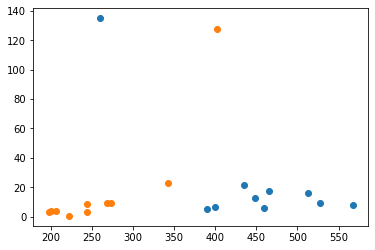

In [111]:
def plot_2_digits(im_set_1,im_set_2):
    set_1_xs = []
    set_1_ys = []
    set_2_xs = []
    set_2_ys = []
    for im_id in range(im_set_1.shape[0]):
        # get descriptors 
        set_1_descriptors = get_fourier_descriptors(im_set_1[im_id])
        set_2_descriptors = get_fourier_descriptors(im_set_2[im_id])
        # get amplitudes for 2d plot
        set_1_x, set_1_y = get_amplitude(set_1_descriptors)
        set_2_x, set_2_y = get_amplitude(set_2_descriptors)
        set_1_xs.append(set_1_x)
        set_1_ys.append(set_1_y)
        set_2_xs.append(set_2_x)
        set_2_ys.append(set_2_y)
    # plot
    fig,ax = plt.subplots()
    ax.scatter(set_1_xs,set_1_ys)
    ax.scatter(set_2_xs,set_2_ys)
    
def get_amplitude(descriptors):
    amplitudes = []
    for d in descriptors:
        amplitudes.append(np.sqrt(d.real**2+d.imag**2))
    return amplitudes

plot_2_digits(zeros_thresholded,ones_thresholded)

### 1.3 Additional method (5 pts)

Starting with PCA

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [12]:
X = np.concatenate((ones_im, zeros_im))
X = np.reshape(X, (20, 28*28))
X = normalize(X, axis=0) # axis=0 normalizes each feature (column-wise)

In [13]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [14]:
transform = pca.transform(X)

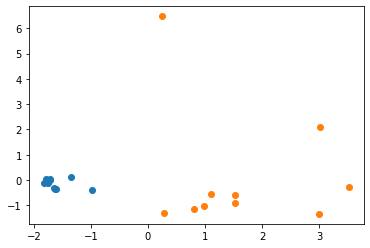

In [15]:
plt.scatter(transform[0:10,0], transform[0:10,1]) # Zeros
plt.scatter(transform[10:20,0], transform[10:20,1]) # Ones

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

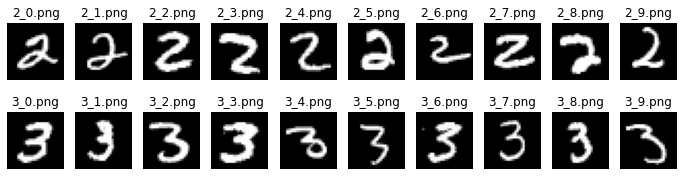

In [107]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [108]:
# Add your implementation and discussion
twos_thresholded = process_digit(twos_im)
three_thresholded = process_digit(threes_im)

In [112]:
def plot_4_digits(im_set_1,im_set_2,im_set_3,im_set_4):
    set_1_xs = []
    set_1_ys = []
    set_2_xs = []
    set_2_ys = []
    set_3_xs = []
    set_3_ys = []
    set_4_xs = []
    set_4_ys = []
    for im_id in range(im_set_1.shape[0]):
        # get descriptors 
        set_1_descriptors = get_fourier_descriptors(im_set_1[im_id])
        set_2_descriptors = get_fourier_descriptors(im_set_2[im_id])
        set_3_descriptors = get_fourier_descriptors(im_set_3[im_id])
        set_4_descriptors = get_fourier_descriptors(im_set_4[im_id])
        # get amplitudes for 2d plot
        set_1_x, set_1_y = get_amplitude(set_1_descriptors)
        set_2_x, set_2_y = get_amplitude(set_2_descriptors)
        set_3_x, set_3_y = get_amplitude(set_3_descriptors)
        set_4_x, set_4_y = get_amplitude(set_4_descriptors)
        set_1_xs.append(set_1_x)
        set_1_ys.append(set_1_y)
        set_2_xs.append(set_2_x)
        set_2_ys.append(set_2_y)
        set_3_xs.append(set_3_x)
        set_3_ys.append(set_3_y)
        set_4_xs.append(set_4_x)
        set_4_ys.append(set_4_y)
    # plot
    fig,ax = plt.subplots()
    ax.scatter(set_1_xs,set_1_ys)
    ax.scatter(set_2_xs,set_2_ys)
    ax.scatter(set_3_xs,set_3_ys)
    ax.scatter(set_4_xs,set_4_ys)

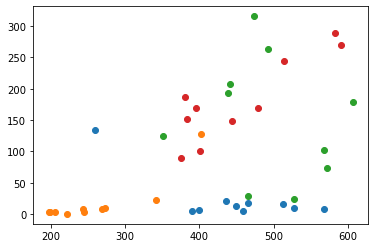

In [113]:
plot_4_digits(zeros_thresholded,ones_thresholded,twos_thresholded,three_thresholded)